In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch

sys.path.append('../')

from src_experiment import NeuralNet, moon_path, wbc_path, get_moons_data, get_wbc_data
from geobin import RegionTree, TreeNode

In [2]:
# test params
experiment = "moon"
arch = "decreasing"
dropout = 0.0
noise = 0.0
run_number = 0
path_fn = moon_path if experiment == "moon" else wbc_path
data_fn = get_moons_data if experiment == "moon" else get_wbc_data

In [3]:
# Load the state dicts
epochs = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,74]
state_dicts = {epoch: path_fn(arch, dropout, noise, run_number) /"state_dicts"/f"epoch{epoch}.pth" for epoch in epochs}

In [4]:
# Get the testing data
_, data = data_fn(noise, batch_size=32)
len(data)

7

In [5]:
ncounts_per_epoch = {}
total_times = []
building_times = []
passing_times = []
for epoch in epochs:
    start = time.time()
    state_dict = torch.load(state_dicts[epoch])
    tree = RegionTree(state_dict)
    tree.build_tree(verbose=False, check_feasibility=False)
    intermediate = time.time()
    tree.pass_dataloader_through_tree(data)
    tree.collect_number_counts()
    ncounts_per_epoch[epoch] = tree.get_number_counts()
    # print(tree.size)
    end = time.time()
    total_time = end-start
    building_time = intermediate-start
    passing_time = end-intermediate
    
    total_times.append(total_time)
    building_times.append(building_time)
    passing_times.append(passing_time)
    print(f"\nEpoch: {epoch}")
    print(f"Total time taken:    {total_time:.3f} s")
    print(f"Time building:       {building_time:.3f} s")
    print(f"Time passing:        {passing_time:.3f} s")


# print(f"Time taken (checking): {end-start:.3f} s")



Epoch: 0
Total time taken:    0.298 s
Time building:       0.268 s
Time passing:        0.030 s

Epoch: 5
Total time taken:    0.259 s
Time building:       0.232 s
Time passing:        0.027 s

Epoch: 10
Total time taken:    0.259 s
Time building:       0.232 s
Time passing:        0.027 s

Epoch: 15
Total time taken:    0.259 s
Time building:       0.231 s
Time passing:        0.028 s

Epoch: 20
Total time taken:    0.256 s
Time building:       0.230 s
Time passing:        0.026 s

Epoch: 25
Total time taken:    0.394 s
Time building:       0.368 s
Time passing:        0.026 s

Epoch: 30
Total time taken:    0.253 s
Time building:       0.225 s
Time passing:        0.028 s

Epoch: 35
Total time taken:    0.259 s
Time building:       0.231 s
Time passing:        0.028 s

Epoch: 40
Total time taken:    0.262 s
Time building:       0.236 s
Time passing:        0.026 s

Epoch: 45
Total time taken:    0.275 s
Time building:       0.244 s
Time passing:        0.031 s

Epoch: 50
Total time 

In [6]:
ncounts_per_epoch_checked = {}
total_times_c = []
building_times_c = []
passing_times_c = []
for epoch in epochs:
    start = time.time()
    state_dict = torch.load(state_dicts[epoch])
    tree = RegionTree(state_dict)
    tree.build_tree(verbose=False, check_feasibility=True)
    intermediate = time.time()
    tree.pass_dataloader_through_tree(data)
    tree.collect_number_counts()
    ncounts_per_epoch_checked[epoch] = tree.get_number_counts()
    # print(tree.size)
    end = time.time()
    total_time = end-start
    building_time = intermediate-start
    passing_time = end-intermediate
    
    total_times_c.append(total_time)
    building_times_c.append(building_time)
    passing_times_c.append(passing_time)
    print(f"\nEpoch: {epoch}")
    print(f"Total time taken:    {total_time:.3f} s")
    print(f"Time building:       {building_time:.3f} s")
    print(f"Time passing:        {passing_time:.3f} s")


Epoch: 0
Total time taken:    0.741 s
Time building:       0.730 s
Time passing:        0.011 s

Epoch: 5
Total time taken:    0.819 s
Time building:       0.809 s
Time passing:        0.011 s

Epoch: 10
Total time taken:    0.867 s
Time building:       0.856 s
Time passing:        0.011 s

Epoch: 15
Total time taken:    1.015 s
Time building:       1.003 s
Time passing:        0.012 s

Epoch: 20
Total time taken:    0.921 s
Time building:       0.910 s
Time passing:        0.012 s

Epoch: 25
Total time taken:    0.906 s
Time building:       0.893 s
Time passing:        0.013 s

Epoch: 30
Total time taken:    1.015 s
Time building:       1.003 s
Time passing:        0.012 s

Epoch: 35
Total time taken:    0.849 s
Time building:       0.838 s
Time passing:        0.012 s

Epoch: 40
Total time taken:    0.996 s
Time building:       0.984 s
Time passing:        0.011 s

Epoch: 45
Total time taken:    0.982 s
Time building:       0.970 s
Time passing:        0.012 s

Epoch: 50
Total time 

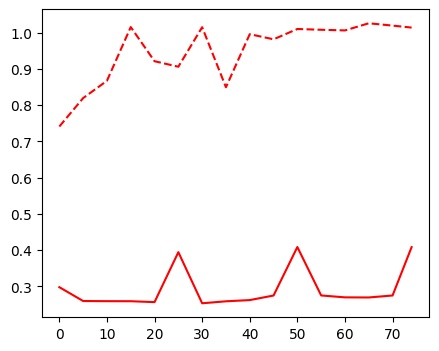

In [7]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(epochs, total_times, color="red", ls="-", label="Total")
ax.plot(epochs, total_times_c, color="red", ls="--")

# ax.plot(epochs, building_times, color="blue", ls="-", label="Building")
# ax.plot(epochs, building_times_c, color="blue", ls="--")

# ax.plot(epochs, passing_times, color="green", ls="-", label="Passing")
# ax.plot(epochs, passing_times_c, color="green", ls="--")

# ax.set_yscale("log")

## Region analysis

In [16]:
layers = ncounts_per_epoch[0]["layer_idx"].unique()
nr_regions_pr_layer = {layer: [] for layer in layers}
for epoch, frame in ncounts_per_epoch_checked.items():
    for layer in frame["layer_idx"].unique():
        nr_regions = len(frame[frame["layer_idx"]==layer])
        nr_regions_pr_layer[layer].append(nr_regions)
nr_regions_pr_layer

{np.int64(1): [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
 np.int64(2): [34, 39, 43, 56, 49, 49, 57, 40, 53, 53, 55, 55, 55, 55, 55, 55],
 np.int64(3): [48, 56, 64, 87, 81, 76, 87, 71, 89, 85, 91, 91, 91, 91, 91, 91],
 np.int64(4): [54,
  68,
  78,
  101,
  94,
  89,
  101,
  87,
  107,
  104,
  110,
  110,
  110,
  110,
  110,
  110]}

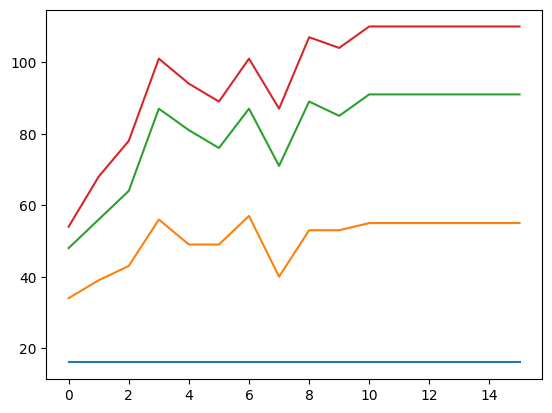

In [17]:
for layer, regions in nr_regions_pr_layer.items():
    plt.plot(regions, label=f"Layer {layer}")
plt.show()

## Estimates

In [18]:
from src_experiment import DivergenceEngine, QUANTITIES_TO_ESTIMATE
from typing import Dict, List
class EstimateQuantities1Run:
    """
    Experiment-specific wrapper that:
    - loads number counts
    - loops over epochs
    - delegates all math to DivergenceEngine
    """

    def __init__(
        self,
        ncounts
    ):
        self.ncounts = ncounts

        self.estimates: Dict[str, List[pd.DataFrame]] = {
            q: [] for q in QUANTITIES_TO_ESTIMATE
        }

        # Perform calculations
        self.calculate_estimates()

    # ------------------------------------------------------------------

    def calculate_estimates(self) -> None:
        for epoch, frame in self.ncounts.items():
            engine = DivergenceEngine(frame)
            epoch_results = engine.compute()

            for key, df in epoch_results.items():
                df.insert(0, "epoch", epoch)
                self.estimates[key].append(df)

        # Concatenate epochs
        for key, frames in self.estimates.items():
            self.estimates[key] = (
                pd.concat(frames, ignore_index=True)
                .rename_axis(None, axis=1)
            )

    def get_estimates(self) -> Dict[str, pd.DataFrame]:
        return self.estimates


In [19]:
est1 = EstimateQuantities1Run(ncounts_per_epoch)
est2 = EstimateQuantities1Run(ncounts_per_epoch_checked)


/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:117: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / self.m_w
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m

In [20]:
n1 = est1.get_estimates()
n2 = est2.get_estimates()
for Q in QUANTITIES_TO_ESTIMATE:
    assert np.all(np.abs(n1[Q] - n2[Q]) < 1e-6)

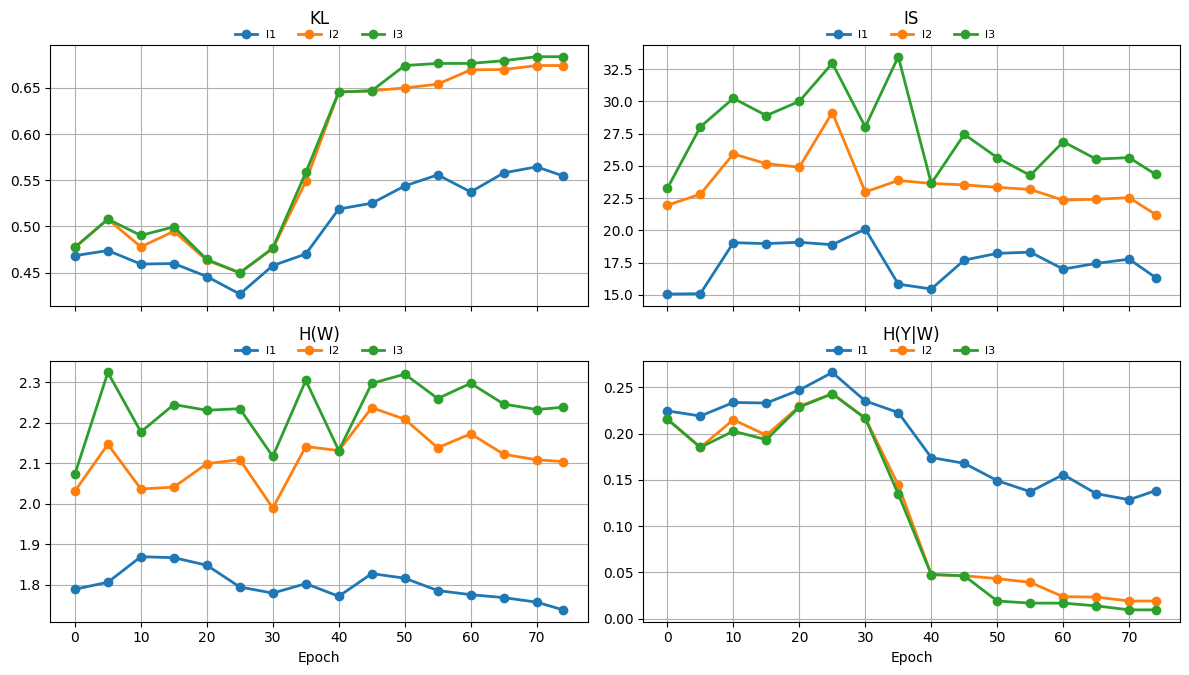

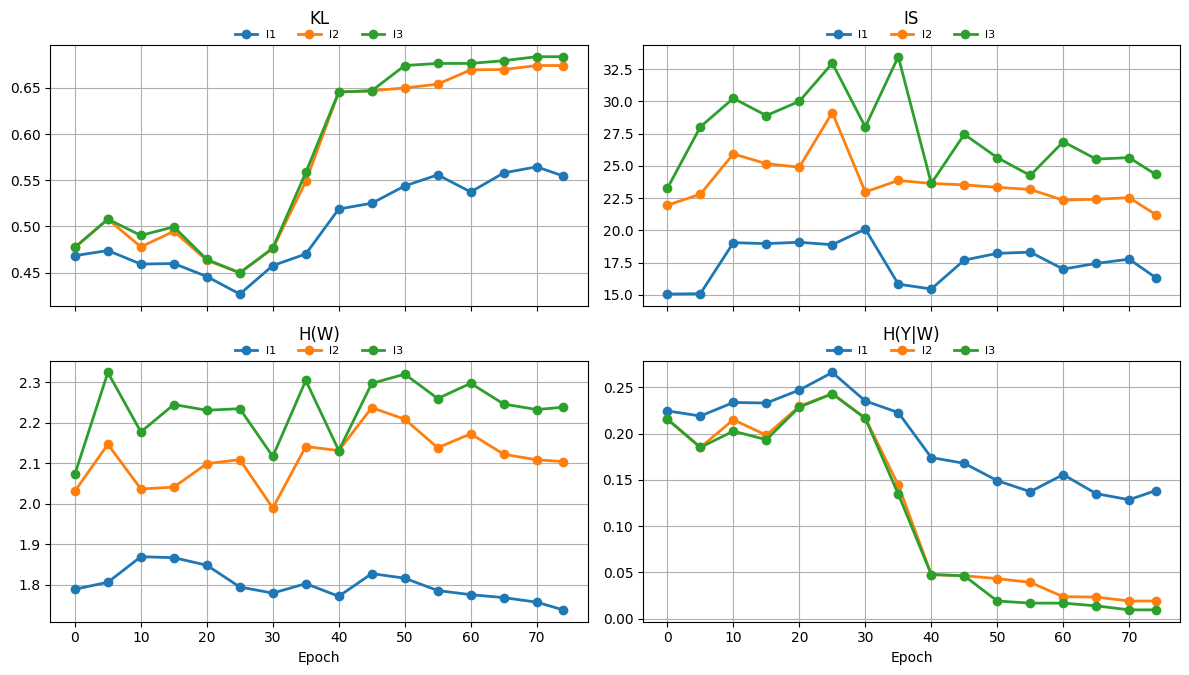

In [21]:
from visualization import plot_all_quantities
plot_all_quantities(est1.get_estimates())
plot_all_quantities(est2.get_estimates())